In [2]:
import pandas as pd
import os
import re

In [17]:
main_directory = "/media/molecularonco/New Volume/exome/"

### Creating a general filter for files generated by annovar and remove unnecessary informations:
    - Removing:
        -synonymous SNPs
        -benign mutations
        -gnomad info other than EAS
    - Added conditional statement for:
        -matching 494 cancer-related genes
        -marked as 'deleterious' or 'disease causing' by a predictive algorithm

In [9]:
directory = "/media/molecularonco/New Volume/exome/annovar"

# List of multianno files
multianno_files = [f for f in os.listdir(directory) if f.endswith("hg38_multianno.csv")]

# Define the filters
exonic_func_filter = ["synonymous SNV"]
clnsig_filter = ["Benign", "Benign/Likely_benign", "Likely_benign"]
gnomad_af_threshold = 0.01
cadd_phred_threshold = 20
revel_threshold = 0.5

# Columns to drop
columns_to_drop = [
    "gnomad312_AF_XX", "gnomad312_AF_XY", "gnomad312_AF_popmax",
    "gnomad312_AF_faf95_popmax", "gnomad312_AF_afr", "gnomad312_AF_ami",
    "gnomad312_AF_amr", "gnomad312_AF_asj", "AAChange.refGene",
    "gnomad312_AF_fin", "gnomad312_AF_mid", "gnomad312_AF_nfe",
    "gnomad312_AF_oth", "gnomad312_AF_sas", "GeneDetail.refGene",
    "LRT_score", "LRT_pred", "LR_score", "LR_pred", "VEST3_score",
    "GERP++_RS", "phyloP46way_placental", "phyloP100way_vertebrate", "SiPhy_29way_logOdds"
]

# List of genes to match
genes_to_match = [
    'ABCB1', 'CAMTA1', 'CRKL', 'ERCC6', 'GATA2', 'JUN', 'MMS19', 'OSM', 'PRKAR1A', 'RSPO3', 'TEK',
    'ABCB5', 'CARD11', 'CRTC1', 'ERG', 'GLI1', 'KDM5A', 'MN1', 'OSMR', 'PTCH1', 'RUNX1', 'TERT',
    'ABL1', 'CBL', 'CSF1R', 'ERRFI1', 'GLI2', 'KDM5C', 'MPL', 'P3H1', 'PTCH2', 'SBDS', 'TET1',
    'ABL2', 'CCND1', 'CSF2RA', 'ESR1', 'GLI3', 'KDM6A', 'MRE11', 'PAK4', 'PTEN', 'SDHA', 'TET2',
    'ABRAXAS1', 'CCND2', 'CSF3R', 'ETS1', 'GNA11', 'KDR', 'MS4A1', 'PALB2', 'PTGFR', 'SDHAF2', 'TFE3',
    'ADORA2A', 'CCND3', 'CTAG1B', 'EWSR1', 'GNAQ', 'KIF1B', 'MSH2', 'PARP1', 'PTPN1', 'SDHB', 'TGFB1',
    'AIP', 'CCNE1', 'CTLA4', 'EXT1', 'GNAS', 'KIR2DL1', 'MSH6', 'PARP2', 'PTPN11', 'SDHC', 'TMEM127',
    'AKT1', 'CCR2', 'CTNNB1', 'EXT2', 'GPC3', 'KIR2DL2', 'MSLN', 'PARP3', 'PTPN12', 'SDHD', 'TMPRSS2',
    'AKT2', 'CCR4', 'CXCL12', 'EZH2', 'GPRC5A', 'KIR2DL3', 'MST1R', 'PAX3', 'PTPN2', 'SEM1', 'TMSB4X',
    'AKT3', 'CCR5', 'CXCR4', 'FAM30A', 'GRM1', 'KIT', 'MTOR', 'PAX5', 'PTPRF', 'SETD2', 'TNFAIP3',
    'ALK', 'CD19', 'CYLD', 'FANCA', 'GSTM1', 'KITLG', 'MUTYH', 'PAX7', 'PTPRJ', 'SHH', 'TNFRSF18',
    'APC', 'CD27', 'CYP3A5', 'FANCB', 'GSTT1', 'KLB', 'MYB', 'PBRM1', 'PTPRK', 'SLC39A6', 'TNFRSF4',
    'AR', 'CD274', 'DAXX', 'FANCC', 'H3F3A', 'KMT2A', 'MYC', 'PDCD1', 'RAB35', 'SLC39A6', 'TNFRSF9',
    'ARAF', 'CD276', 'DDB1', 'FANCD2', 'HAVCR2', 'KMT2B', 'MYCL1', 'PDCD1LG2', 'RAD18', 'SLFN11', 'TP53',
    'ARHGAP26', 'CD40', 'DDB2', 'FANCE', 'HDAC2', 'KMT2C', 'MYCN', 'PDGFA', 'RAD50', 'SLX4', 'TPTE',
    'ARHGAP6', 'CD5', 'DDIT3', 'FANCF', 'HEY1', 'KMT2D', 'MYCT1', 'PAX3', 'PTPN1', 'SDHB', 'TGFB1',
    'ARHGEF12', 'CD70', 'DDR1', 'FANCG', 'HGF', 'KRAS', 'MYD88', 'PDGFRA', 'RAD51', 'SMAD4', 'TRAP1',
    'ARID1A', 'CD99', 'DICER1', 'FANCL', 'HORMAD1', 'LCK', 'NAMPT', 'PHF1', 'RAD51B', 'SMARCA4', 'TSC1',
    'ASCL1', 'CD79B', 'DDR2', 'FANCM', 'HORMAD2', 'LATS1', 'NAB2', 'PHF6', 'RAD51C', 'SMARCB1', 'TSC2',
    'ASPSCR1', 'CDC73', 'DIS3L2', 'FANCI', 'HLA-A', 'KSR2', 'MYEOV', 'PDGFA', 'RAD51D', 'SMARCE1', 'TSHR',
    'ATM', 'CDH1', 'DLEU1', 'FAS', 'HPS1', 'LCK', 'NAMPT', 'PHF6', 'RAD51D', 'SMARCE1', 'TSHR',
    'ATR', 'CDH17', 'DLL3', 'FASLG', 'HRAS', 'LIG1', 'NBN', 'PHLPP1', 'RAD54B', 'SMO', 'TSSK3',
    'ATRX', 'CDK1', 'DNMT3A', 'FBXW7', 'HSP90AA1', 'LMTK3', 'NCOA2', 'PHOX2B', 'RAF1', 'SOX10', 'UBE2N',
    'AURKA', 'CDK12', 'DOT1L', 'FGF1', 'HSP90AB1', 'LPP', 'NDRG1', 'PIK3C2G', 'RAP1B', 'SPTA1', 'USP11',
    'AURKC', 'CDK2', 'DUX4', 'FGF2', 'HSP90B1', 'LZTR1', 'NF1', 'PIK3CA', 'RARA', 'SRC', 'USP6',
    'AXL', 'CDK4', 'EGF', 'FGF3', 'ICOS', 'MAGEA3', 'NF2', 'PIK3CD', 'RASA1', 'SRSF2', 'VEGFA',
    'B2M', 'CDK5', 'EGFL7', 'FGF4', 'ID2', 'MALAT1', 'NFATC1', 'PIK3R1', 'RASA2', 'SS18', 'VEGFB',
    'BAP1', 'CDK6', 'EGFR', 'FGFR1', 'ID3', 'MAML2', 'NFIB', 'PIK3R2', 'RB1', 'SSRP1', 'VHL',
    'BARD1', 'CDK9', 'EGLN1', 'FGFR2', 'IDO1', 'MAP2K1', 'NFKBIA', 'PIK3R5', 'RECQL', 'SSTR1', 'VSIR',
    'BCL2', 'CDKN1A', 'EGLN2', 'FGFR3', 'IDO2', 'MAP2K2', 'NFKBIE', 'PIM1', 'RECQL4', 'SSTR2', 'WIF1',
    'BCL3', 'CDKN1B', 'EHBP1', 'FGFR4', 'IDO2', 'MAP3K1', 'NOTCH1', 'PIM2', 'RET', 'SSTR3', 'WNK2',
    'BCL6', 'CDKN1C', 'EP300', 'FH', 'IDO2', 'MAP3K6', 'NOTCH2', 'PLAG1', 'RHBDF2', 'SSTR4', 'WRN',
    'BCL9', 'CDKN2A', 'EPAS1', 'FLCN', 'IGF1R', 'MAX', 'NR4A3', 'PLK1', 'RHEB', 'SSTR5', 'WT1',
    'BCOR', 'CDKN2B', 'EPCAM', 'FLI1', 'IKZF1', 'MCL1', 'NRAS', 'PLK2', 'RHOA', 'SSX1', 'WWTR1',
    'BLM', 'CDKN2C', 'EPHA3', 'FLT1', 'IL21R', 'MDH2', 'NRG1', 'PLK3', 'RICTOR', 'SSX2', 'XAB2',
    'BMPR1A', 'CDKN2D', 'EPHA5', 'FLT4', 'IL6', 'MDM2', 'NRG2', 'PMEL', 'RINT1', 'STAT3', 'XPA',
    'BRAF', 'CEBPA', 'EPHB2', 'FLT3', 'IL6R', 'MED12', 'NRG3', 'PMS1', 'RIT1', 'STAT5B', 'XPC',
    'BRCA1', 'CEP57', 'ERBB2', 'FOLH1', 'IL6ST', 'MED12', 'NRG4', 'PMS2', 'RNF2', 'STAT6', 'XPO1',
    'BRCA2', 'CHEK1', 'ERBB3', 'FOXL2', 'IL7R', 'MEN1', 'NSD1', 'PNKP', 'RNF43', 'STK11', 'XRCC1',
    'BRD2', 'CHEK2', 'ERBB4', 'FOXO1', 'IRF4', 'MERTK', 'NT5E', 'POLD1', 'ROR1', 'STK36', 'XRCC2',
    'BRD3', 'CIC', 'ERCC1', 'FOXP1', 'IRS2', 'MET', 'NTRK1', 'POLE', 'ROS1', 'SUFU', 'XRCC3',
    'BRD4', 'CLDN18', 'ERCC2', 'FUS', 'JAK1', 'MITF', 'NTRK2', 'PPM1D', 'RPA1', 'SUZ12', 'YAP1',
    'BRIP1', 'CLDN6', 'ERCC3', 'FYN', 'JAK2', 'MLH1', 'NTRK3', 'PRAME', 'RPTOR', 'SYK', 'YWHAE',
    'BTK', 'CREBBP', 'ERCC4', 'GAK', 'JAK3', 'MLH3', 'NUDT1', 'PRF1', 'RRAS2', 'TACSTD2', 'ZNF217',
    'BUB1B', 'CREBRF', 'ERCC5', 'GAS6', 'JAZF1', 'MLLT1', 'NUTM1', 'PRKACA', 'RSPO2', 'TEAD1'
]

# Process each file
for file in multianno_files:
    sample_id = file.split("_")[0]
    
    # Load the data 
    df = pd.read_csv(os.path.join(directory, file), low_memory=False)
    
    # Drop columns with all NaN values 
    df = df.dropna(axis=1, how='all')
    
    # Add new column 'algorithm' with slash for rows with values in specified columns
    df['algorithm'] = df[['SIFT_pred', 'CADD_phred', 'Polyphen2_HDIV_pred', 'REVEL']].notna().any(axis=1).map({True: '/', False: ''})
    
    # Add new column '500' with slash for rows where Gene.refGene matches any gene in genes_to_match
    df['500'] = df['Gene.refGene'].apply(lambda x: '/' if x in genes_to_match else '')
    
    # Sort DataFrame based on the 'algorithm' and '500' columns
    df = df.sort_values(by=['algorithm', '500'], ascending=[False, False])
    
    # Apply initial filters
    df_filtered = df[
        (~df['ExonicFunc.refGene'].isin(exonic_func_filter)) & 
        (~df['CLNSIG'].isin(clnsig_filter)) & 
        (df['gnomad312_AF_eas'].apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0) <= gnomad_af_threshold)
    ].copy()
    
    # Further filter out rows based on additional criteria
    df_filtered = df_filtered[
        ~(
            (df_filtered['SIFT_pred'] == 'T') &
            (df_filtered['CADD_phred'].apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0) < cadd_phred_threshold) &
            (df_filtered['Polyphen2_HDIV_pred'] == 'B') &
            (df_filtered['REVEL'].apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0) < revel_threshold)
        )
    ].copy()
    
    # Drop specified columns
    df_filtered.drop(columns=columns_to_drop, inplace=True)   
    
    # Save the filtered file
    output_file = f"{sample_id}_filtered.tsv"
    df_filtered.to_csv(os.path.join(directory, output_file), sep='\t', index=False)

#### Load in files generated by <b>oncokb, purecn, varsome and filtered annovar</b> append all into a single file

In [13]:
# Function to merge files
def merge_files(sample_id):
    # Read oncokb file with specified data types to suppress the warning
    oncokb_file = os.path.join(main_directory, "oncokb", f"{sample_id}_oncokb.maf")
    oncokb_df = pd.read_csv(oncokb_file, sep='\t', dtype=str)

    # Read filtered file
    filtered_file = os.path.join(main_directory, "annovar", f"{sample_id}_filtered.tsv")
    filtered_df = pd.read_csv(filtered_file, sep='\t', dtype=str)

    # Convert 'Start_Position' column to string in oncokb_df
    oncokb_df['Start_Position'] = oncokb_df['Start_Position'].astype(str)

    # Convert 'Start' column to string in filtered_df
    filtered_df['Start'] = filtered_df['Start'].astype(str)

    # Merge based on Start_Position for oncokb and Start for filtered.tsv
    merged_df = pd.merge(oncokb_df, filtered_df, left_on='Start_Position', right_on='Start')

    # Add new column 'oncokb' based on conditions
    merged_df['oncokb'] = ''
    condition = (
        merged_df['HIGHEST_LEVEL'].notna() |
        merged_df['HIGHEST_DX_LEVEL'].notna() |
        merged_df['HIGHEST_PX_LEVEL'].notna()
    )
    merged_df.loc[condition, 'oncokb'] = '/'

    return merged_df

# Function to merge with varsome_master_snv
def merge_with_varsome_snv(merged_df, varsome_master_snv_df):
    # Ensure data types for merge columns are strings
    merged_df['Tumor_Sample_Barcode'] = merged_df['Tumor_Sample_Barcode'].astype(str)
    merged_df['Start_Position'] = merged_df['Start_Position'].astype(str)
    varsome_master_snv_df['SampleID'] = varsome_master_snv_df['SampleID'].astype(str)
    varsome_master_snv_df['Position'] = varsome_master_snv_df['Position'].astype(str)

    # Merge based on 'SampleID' and 'Start_Position'
    merged_with_varsome_snv = pd.merge(merged_df, varsome_master_snv_df, how='left', left_on=['Tumor_Sample_Barcode', 'Start_Position'], right_on=['SampleID', 'Position'])
    
    return merged_with_varsome_snv

# Function to merge with varsome_master_indel
def merge_with_varsome_indel(merged_df, varsome_master_indel_df):
    # Ensure data types for merge columns are strings
    merged_df['Tumor_Sample_Barcode'] = merged_df['Tumor_Sample_Barcode'].astype(str)
    merged_df['vcf_pos'] = merged_df['vcf_pos'].astype(str)
    varsome_master_indel_df['SampleID'] = varsome_master_indel_df['SampleID'].astype(str)
    varsome_master_indel_df['Position'] = varsome_master_indel_df['Position'].astype(str)

    # Merge based on 'SampleID' and 'vcf_pos'
    merged_with_varsome_indel = pd.merge(merged_df, varsome_master_indel_df, how='left', left_on=['Tumor_Sample_Barcode', 'vcf_pos'], right_on=['SampleID', 'Position'])
    
    return merged_with_varsome_indel

# Function to merge with variants_sorted
def merge_with_variants_sorted(merged_df, variants_sorted_df):
    # Ensure data types for merge columns are strings
    merged_df['Start_Position'] = merged_df['Start_Position'].astype(str)
    variants_sorted_df['start'] = variants_sorted_df['start'].astype(str)

    # Merge based on 'Start_Position' and 'Start'
    merged_with_variants_sorted = pd.merge(merged_df, variants_sorted_df, left_on='Start_Position', right_on='start', how='left')

    return merged_with_variants_sorted

# Load varsome_master_snv.csv
varsome_master_snv_file = "/media/molecularonco/New Volume/exome/varsome_master_snv.csv"
varsome_master_snv_df = pd.read_csv(varsome_master_snv_file, header=0, dtype=str)

# Load varsome_master_indel.xlsx
varsome_master_indel_file = "/media/molecularonco/New Volume/exome/varsome_master_indel.xlsx"
varsome_master_indel_df = pd.read_excel(varsome_master_indel_file, header=0, dtype=str)

all_samples_df = pd.DataFrame()

# Iterate through files in oncokb folder
oncokb_files = [file for file in os.listdir(os.path.join(main_directory, "oncokb")) if file.endswith("_oncokb.maf")]
for file in oncokb_files:
    sample_id = file.split("_")[0]
    merged_df = merge_files(sample_id)
    
    # Merge with varsome_master_snv.csv
    merged_with_varsome_snv = merge_with_varsome_snv(merged_df, varsome_master_snv_df)
    
    # Merge with varsome_master_indel.xlsx
    merged_with_varsome = merge_with_varsome_indel(merged_with_varsome_snv, varsome_master_indel_df)
    
    # Sort DataFrame
    merged_with_varsome.sort_values(by=['algorithm', '500', 'oncokb'], ascending=[False, False, False], inplace=True)
    
    # Add new column 'varsome' based on conditions
    merged_with_varsome['varsome'] = ''
    
    # Check if 'Somatic Tier_x' or 'Somatic Tier_y' column exists and then apply condition
    if 'Somatic Tier_x' in merged_with_varsome.columns:
        somatic_tier_condition_x = merged_with_varsome['Somatic Tier_x'].notna() & merged_with_varsome['Somatic Tier_x'].str.contains(r'\w+', na=False)
        merged_with_varsome.loc[somatic_tier_condition_x, 'varsome'] = '/'
    if 'Somatic Tier_y' in merged_with_varsome.columns:
        somatic_tier_condition_y = merged_with_varsome['Somatic Tier_y'].notna() & merged_with_varsome['Somatic Tier_y'].str.contains(r'\w+', na=False)
        merged_with_varsome.loc[somatic_tier_condition_y, 'varsome'] = '/'
    
    # Read the variants_sorted.csv file
    variants_sorted_file = os.path.join(main_directory, "purecn", f"{sample_id}_variants.csv")
    variants_sorted_df = pd.read_csv(variants_sorted_file, dtype=str)

    # Merge with variants_sorted_df
    final_merged_df = merge_with_variants_sorted(merged_with_varsome, variants_sorted_df)

    # Add new column 'purecn' based on conditions
    final_merged_df['purecn'] = ''
    purecn_condition = (final_merged_df['ML.M'].astype(float) > 1) & (final_merged_df['CELLFRACTION'].astype(float) > 0.9)
    final_merged_df.loc[purecn_condition, 'purecn'] = '/'

    # Add a new column 'count' to count the number of '/' in specified columns
    final_merged_df['count'] = final_merged_df[['algorithm', '500', 'oncokb', 'purecn', 'varsome']].apply(lambda row: row.str.count('/').sum(), axis=1)
    
    # Sort the DataFrame by 'count' in descending order
    final_merged_df.sort_values(by='count', ascending=False, inplace=True)

    # Save the final merged DataFrame to an Excel file
    output_file = os.path.join(main_directory, "oncokb", f"{sample_id}_final_merged.xlsx")
    final_merged_df.to_excel(output_file, index=False)
    
    # Concatenate to the all_samples_df
    all_samples_df = pd.concat([all_samples_df, final_merged_df])

# Sort the all_samples_df by 'count' in descending order
all_samples_df.sort_values(by='count', ascending=False, inplace=True)

#### For ease of access split the all_samples_df into smaller files

In [14]:
# Select the columns for the summarized file
summarized_columns = [
    'Tumor_Sample_Barcode', 'Chr_x', 'Start_x', 'End_x', 'Ref_x', 'Alt_x', 
    'Func.refGene_x', 'Gene.refGene_x', 'ExonicFunc.refGene_x', 'GeneDetail.refGene_x', 'AAChange.refGene_x', 
    'algorithm', '500', 'oncokb', 'varsome', 'purecn'
]
summarized_df = all_samples_df[summarized_columns]

# Save the summarized file
summarized_file = os.path.join(main_directory, "summarized.csv")
summarized_df.to_csv(summarized_file, index=False)

# Select the columns for the algorithm file
algorithm_columns = [
    'Tumor_Sample_Barcode', 'Chr_x', 'Start_x', 'End_x', 'Ref_x', 'Alt_x', 'Func.refGene_x', 
    'Gene.refGene_x', 'ExonicFunc.refGene_x', 'SIFT_score', 'SIFT_pred', 
    'MutationTaster_score', 'MutationTaster_pred','FATHMM_score', 'FATHMM_pred', 'Polyphen2_HVAR_score', 
    'Polyphen2_HVAR_pred', 'CADD_raw', 
    'CADD_phred', 'CLNALLELEID', 'CLNDN', 'CLNDISDB', 'CLNREVSTAT', 
    'CLNSIG', 'REVEL'
]
algorithm_df = all_samples_df[algorithm_columns]

# Save the algorithm file
algorithm_file = os.path.join(main_directory, "algorithm.csv")
algorithm_df.to_csv(algorithm_file, index=False)

# Select the columns for the oncokb file
oncokb_columns = [
    'Tumor_Sample_Barcode', 'vcf_pos', 'Ref_x', 'Alt_x', 'ANNOTATED', 'ONCOKB_HUGO_SYMBOL', 'ONCOKB_CONSEQUENCE', 
    'GENE_IN_ONCOKB', 'VARIANT_IN_ONCOKB', 'MUTATION_EFFECT', 
    'MUTATION_EFFECT_CITATIONS', 'ONCOGENIC', 'HIGHEST_LEVEL', 
    'HIGHEST_DX_LEVEL', 'HIGHEST_PX_LEVEL'
]
oncokb_df = all_samples_df[oncokb_columns]

# Save the oncokb file
oncokb_file = os.path.join(main_directory, "oncokb.csv")
oncokb_df.to_csv(oncokb_file, index=False)

varsome_columns = [
    'SampleID_x', 'Position_x', 'Reference_x', 'Alternate_x', 'RS ID_x', 
    'HGVS_x', 'Genes_x', 'Function_x', 'Functions of ACMG transcript_x', 
    'Coding impact_x', 'Inheritance_x', 'Somatic Tier_x'
]
varsome_df = all_samples_df[varsome_columns]

# Save the varsome file
varsome_file = os.path.join(main_directory, "varsome.csv")
varsome_df.to_csv(varsome_file, index=False)

# Select the columns for the purecn file
purecn_columns = [
    'Sampleid', 'chr', 'start', 'end', 'ML.M', 'CELLFRACTION', 'gene.symbol'
]
purecn_df = all_samples_df[purecn_columns]

# Save the purecn file
purecn_file = os.path.join(main_directory, "purecn.csv")
purecn_df.to_csv(purecn_file, index=False)

#### Another round of filtering keeping variants that fulfill the following criteria:
    - present in annovar, oncokb and varsome database

In [16]:
# Keep rows where 'algorithm', '500', 'oncokb', 'varsome' contain '/'
onco_df = summarized_df[
    summarized_df['algorithm'].str.contains('/') &
    summarized_df['500'].str.contains('/') |
    summarized_df['oncokb'].str.contains('/') ]
    #summarized_df['varsome'].str.contains('/')

onco_df = onco_df[~onco_df['ExonicFunc.refGene_x'].isin(['nonframeshift substitution', 'nonframeshift deletion'])]

# Display 
onco_df

,Tumor_Sample_Barcode,Chr_x,Start_x,End_x,Ref_x,Alt_x,Func.refGene_x,Gene.refGene_x,ExonicFunc.refGene_x,GeneDetail.refGene_x,AAChange.refGene_x,algorithm,500,oncokb,varsome,purecn
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,NaN,/,/,/,/,
0,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,NaN,/,/,/,,/
0,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,"ATM:NM_000051:exon63:c.C9139T:p.R3047X,ATM:NM_...",/,/,/,/,
0,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,NaN,/,/,/,,/
1,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,NaN,/,/,/,,/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr11,102328878,102328880,ATA,-,intronic,BIRC3,NaN,NaN,NaN,NaN,NaN,/,,
1349,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr19,1646433,1646437,GGGAG,-,intronic,TCF3,NaN,NaN,NaN,NaN,NaN,/,,
712,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,NaN,NaN,NaN,/,,
530,z8597_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr10,8073911,8073911,-,G,exonic,GATA3,frameshift insertion,NaN,NaN,NaN,NaN,/,,


In [79]:
# Save the file for oncoplot
oncoplot_file = os.path.join(directory, "oncoplot.txt")
onco_df.to_csv(oncoplot_file, sep="\t", index=False)

In [17]:
oncokb_df = oncokb_df.drop_duplicates(subset=['Tumor_Sample_Barcode', 'vcf_pos'], keep='first')
onco_oncokb_df = pd.merge(onco_df, oncokb_df, left_on = ['Tumor_Sample_Barcode','Start_x'], right_on = ['Tumor_Sample_Barcode','vcf_pos'], how = 'left', indicator = True)
onco_oncokb_df

,Tumor_Sample_Barcode,Chr_x,Start_x,End_x,Ref_x_x,Alt_x_x,Func.refGene_x,Gene.refGene_x,ExonicFunc.refGene_x,GeneDetail.refGene_x,...,ONCOKB_CONSEQUENCE,GENE_IN_ONCOKB,VARIANT_IN_ONCOKB,MUTATION_EFFECT,MUTATION_EFFECT_CITATIONS,ONCOGENIC,HIGHEST_LEVEL,HIGHEST_DX_LEVEL,HIGHEST_PX_LEVEL,_merge
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,...,splice_acceptor_variant,True,True,Likely Loss-of-function,19336573;27759562;16007150;11753428;11900253;2...,Likely Oncogenic,NaN,NaN,LEVEL_Px1,both
1,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,...,missense_variant,True,True,Gain-of-function,16322248;30206110;20593314;16432179;26627007;1...,Oncogenic,LEVEL_1,NaN,NaN,both
2,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,...,stop_gained,True,True,Likely Loss-of-function,19431188,Likely Oncogenic,LEVEL_1,NaN,NaN,both
3,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,...,missense_variant,True,True,Gain-of-function,16322248;30206110;19029981;22960745;31911549;1...,Oncogenic,LEVEL_1,NaN,NaN,both
4,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,...,missense_variant,True,True,Likely Loss-of-function,29979965;30224644;27328919;12826609;10764158,Likely Oncogenic,NaN,NaN,LEVEL_Px1,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr11,102328878,102328880,ATA,-,intronic,BIRC3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2160,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr19,1646433,1646437,GGGAG,-,intronic,TCF3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2161,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,...,frameshift_variant,True,False,Likely Gain-of-function,15361840;35154280;29535312;32232341;27588951;2...,Likely Oncogenic,NaN,LEVEL_Dx3,NaN,both
2162,z8597_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr10,8073911,8073911,-,G,exonic,GATA3,frameshift insertion,NaN,...,frameshift_variant,True,False,Likely Gain-of-function,15361840;35154280;29535312;32232341;27588951;2...,Likely Oncogenic,NaN,LEVEL_Dx3,NaN,both


In [18]:
algorithm_df = algorithm_df.drop_duplicates(subset=['Tumor_Sample_Barcode', 'Start_x'], keep='first')
onco_oncokb_df = pd.merge(onco_oncokb_df, algorithm_df, left_on= ['Tumor_Sample_Barcode', 'Start_x'], right_on=['Tumor_Sample_Barcode', 'Start_x'], how='left')
onco_oncokb_df

,Tumor_Sample_Barcode,Chr_x_x,Start_x,End_x_x,Ref_x_x,Alt_x_x,Func.refGene_x_x,Gene.refGene_x_x,ExonicFunc.refGene_x_x,GeneDetail.refGene_x,...,Polyphen2_HVAR_score,Polyphen2_HVAR_pred,CADD_raw,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,...,.,.,3.337,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN
1,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,...,0.909,D,5.703,36.0,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654
2,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,...,.,.,16.492,50.0,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN
3,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,...,0.085,B,2.506,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455
4,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,...,1.0,D,4.537,24.5,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr11,102328878,102328880,ATA,-,intronic,BIRC3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2160,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr19,1646433,1646437,GGGAG,-,intronic,TCF3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2161,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2162,z8597_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr10,8073911,8073911,-,G,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Main Criteria in filtering the variants:
    - predicted as "deleterious" or "damaging" by 3 out of 4 predictive tools
    - CADD score > 20 or REVEL > 0.5
    - Clinvar or OncoKB as pathogenic/oncogenic

In [19]:
print(onco_oncokb_df['CLNSIG'].unique())

['Pathogenic/Likely_pathogenic' 'Pathogenic'
 'Conflicting_interpretations_of_pathogenicity' nan 'Likely_pathogenic'
 'Uncertain_significance' 'Pathogenic/Likely_pathogenic|drug_response'
 'not_provided' 'risk_factor' 'other']


In [87]:
# Create a copy of the original DataFrame
filtered_df = onco_oncokb_df.copy()

# Apply filters only to missense_variant rows
missense_df = filtered_df[
    (filtered_df['ONCOKB_CONSEQUENCE'] == 'missense_variant') | 
    (filtered_df['ONCOKB_CONSEQUENCE'].isna())
]

# Ensure numeric types for CADD_phred and REVEL (suppress errors to handle non-convertible strings)
missense_df['CADD_phred'] = pd.to_numeric(missense_df['CADD_phred'], errors='coerce')
missense_df['REVEL'] = pd.to_numeric(missense_df['REVEL'], errors='coerce')

# Check for Pathogenic or Likely Pathogenic in OncoKB or ClinVar
pathogenic_conditions = (
    (missense_df['ONCOGENIC'].isin(['Likely Oncogenic', 'Oncogenic'])) |
    (missense_df['CLNSIG'].isin([
        'Pathogenic/Likely_pathogenic', 'Pathogenic', 'Uncertain_significance',
        'Conflicting_interpretations_of_pathogenicity', 'Likely_pathogenic', 
        'Pathogenic/Likely_pathogenic|drug_response'
    ]))
)

# Check if 3 out of 4 prediction scorers classify as damaging or deleterious
sift_d = missense_df['SIFT_pred'] == 'D'
fathmm_d = missense_df['FATHMM_pred'] == 'D'
polyphen_d_p = missense_df['Polyphen2_HVAR_pred'].isin(['D', 'P'])
mutationtaster_d_a = missense_df['MutationTaster_pred'].isin(['D', 'A'])
damaging_score = sift_d + fathmm_d + polyphen_d_p + mutationtaster_d_a
scorer_condition = damaging_score >= 3

# Check for CADD_phred > 19.45 or REVEL > 0.45
cadd_revel_condition = (
    (missense_df['CADD_phred'] > 19.45) |
    (missense_df['REVEL'] > 0.45)
)

# Combine all conditions (only need to satisfy at least one)
combined_conditions = pathogenic_conditions | scorer_condition | cadd_revel_condition

# Filter missense variants based on combined conditions
missense_df = missense_df[combined_conditions]

# Keep all other non-missense variants
non_missense_df = filtered_df[
    (filtered_df['ONCOKB_CONSEQUENCE'] != 'missense_variant') & 
    (filtered_df['ONCOKB_CONSEQUENCE'].notna())
]

# Combine filtered missense_variant rows and non-missense rows
combined_df = pd.concat([missense_df, non_missense_df])

# Ensure the order remains as the original
combined_df = combined_df.sort_index()

# Result
combined_df


/tmp/ipykernel_31869/2280019112.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missense_df['CADD_phred'] = pd.to_numeric(missense_df['CADD_phred'], errors='coerce')
/tmp/ipykernel_31869/2280019112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missense_df['REVEL'] = pd.to_numeric(missense_df['REVEL'], errors='coerce')


,Tumor_Sample_Barcode,Chr_x_x,Start_x,End_x_x,Ref_x_x,Alt_x_x,Func.refGene_x_x,Gene.refGene_x_x,ExonicFunc.refGene_x_x,GeneDetail.refGene_x,...,Polyphen2_HVAR_score,Polyphen2_HVAR_pred,CADD_raw,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,...,.,.,3.337,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN
1,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,...,0.909,D,5.703,36.0,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654
2,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,...,.,.,16.492,50.0,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN
3,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,...,0.085,B,2.506,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455
4,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,...,1.0,D,4.537,24.5,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr10,8073911,8073911,-,T,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2156,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr10,8073910,8073910,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2157,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr10,8073940,8073940,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2161,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
combined_df = combined_df.rename(columns={'sample_id':'Sample_ID', 'Chr_x_x':'Chr', 'Start_x':'Start', 'End_x_x':'End', 'Ref_x_x':'Ref', 'Alt_x_x':'Alt', 'Func.refGene_x_x': 'Func.refGene', 'Gene.refGene_x_x':'Gene.refGene', 'ExonicFunc.refGene_x_x':'ExonicFunc.refGene', 'GeneDetail.refGene_x':'GeneDetail.refGene', 'AAChange.refGene_x': 'AAChange.refGene'})
combined_df

,Tumor_Sample_Barcode,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,ExonicFunc.refGene,GeneDetail.refGene,...,Polyphen2_HVAR_score,Polyphen2_HVAR_pred,CADD_raw,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,...,.,.,3.337,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN
1,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,...,0.909,D,5.703,36.0,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654
2,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,...,.,.,16.492,50.0,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN
3,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,...,0.085,B,2.506,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455
4,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,...,1.0,D,4.537,24.5,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr10,8073911,8073911,-,T,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2156,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr10,8073910,8073910,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2157,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr10,8073940,8073940,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2161,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# # Assuming combined_df and combined_df_2 are pandas DataFrames
# diff_rows = pd.concat([combined_df_2, combined_df]).drop_duplicates(keep=False)

# # Print the resulting DataFrame
# oncoplot_file = os.path.join(directory, "diff.txt")
# diff_rows.to_csv(oncoplot_file, sep="\t", index=False)

### Adding HGVS nomenclature
    - Import files generated by Annovar annotate_variation.pl
    - Extract only the transcript id and genomic change to column hgvs_sum
    - Combine the extracted hgvs to the main df (combined_df) 

In [92]:
# to add hgvs
folder_path = '/home/molecularonco/github/nccs-exome2/result/030_annovar/hgvs'

# Initialize an empty list to store the data
variant_data = []

# Loop through the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.exonic_variant_function'):
        # Extract the sample ID from the filename (assuming it's the part before the first '.')
        sample_id = filename.split('.')[0]
        
        # Open and read the file
        with open(os.path.join(folder_path, filename), 'r') as file:
            for line in file:
                line = line.strip().split('\t')
                # Extract HGVS notation (assumed to be the 3rd field)
                hgvs_notation = line[2]
                # Extract chromosome, start, and end (assumed to be 4th, 5th, and 6th fields)
                chrom = line[3]
                start = line[4]
                end = line[5]
                
                # Append the extracted information to the list
                variant_data.append([sample_id, hgvs_notation, chrom, start, end])

# Create a DataFrame from the collected data
hgvs_df = pd.DataFrame(variant_data, columns=['Sample_ID', 'HGVS', 'Chr', 'Start', 'End'])

# Display the DataFrame
hgvs_df

,Sample_ID,HGVS,Chr,Start,End
0,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_001385641:exon1:c.102A>G:p.P34P,SAMD...",chr1,924533,924533
1,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon3:c.232C>T:p.H78Y,SAMD11:...",chr1,930314,930314
2,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon5:c.369C>G:p.P123P,SAMD11...",chr1,935835,935835
3,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon10:c.1027T>C:p.W343R,SAMD...",chr1,942451,942451
4,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon14:c.1830C>T:p.Y610Y,SAMD...",chr1,943937,943937
...,...,...,...,...,...
2623959,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,"GAB3:NM_001081573:exon9:c.1559G>C:p.S520T,GAB3...",chrX,154680220,154680220
2623960,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,"DKC1:NM_001142463:exon5:c.369G>T:p.T123T,DKC1:...",chrX,154766321,154766321
2623961,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,DKC1:NM_001142463:exon15:c.1477_1479del:p.493_...,chrX,154776814,154776816
2623962,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,"MPP1:NM_002436:exon3:c.255G>T:p.T85T,MPP1:NM_0...",chrX,154791839,154791839


In [93]:
# Function to extract the transcript and variant
def extract_hgvs_sum(hgvs):
    # If the HGVS string contains multiple variants, split by the first comma
    if ',' in hgvs:
        first_variant = hgvs.split(',')[0]
    else:
        first_variant = hgvs
    
    # Split by colons and extract the relevant parts
    variant_parts = first_variant.split(':')
    
    # Check if the string has enough parts to form the desired HGVS sum
    if len(variant_parts) >= 4:
        hgvs_sum = f'{variant_parts[1]}:{variant_parts[3]}'  # Transcript ID and variant
    else:
        hgvs_sum = None  # If the format is unexpected, return None
    
    return hgvs_sum

# Apply the function to the HGVS column to create the 'hgvs_sum' column
hgvs_df['hgvs_sum'] = hgvs_df['HGVS'].apply(extract_hgvs_sum)

hgvs_df

,Sample_ID,HGVS,Chr,Start,End,hgvs_sum
0,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_001385641:exon1:c.102A>G:p.P34P,SAMD...",chr1,924533,924533,NM_001385641:c.102A>G
1,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon3:c.232C>T:p.H78Y,SAMD11:...",chr1,930314,930314,NM_152486:c.232C>T
2,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon5:c.369C>G:p.P123P,SAMD11...",chr1,935835,935835,NM_152486:c.369C>G
3,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon10:c.1027T>C:p.W343R,SAMD...",chr1,942451,942451,NM_152486:c.1027T>C
4,z5231_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,"SAMD11:NM_152486:exon14:c.1830C>T:p.Y610Y,SAMD...",chr1,943937,943937,NM_152486:c.1830C>T
...,...,...,...,...,...,...
2623959,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,"GAB3:NM_001081573:exon9:c.1559G>C:p.S520T,GAB3...",chrX,154680220,154680220,NM_001081573:c.1559G>C
2623960,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,"DKC1:NM_001142463:exon5:c.369G>T:p.T123T,DKC1:...",chrX,154766321,154766321,NM_001142463:c.369G>T
2623961,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,DKC1:NM_001142463:exon15:c.1477_1479del:p.493_...,chrX,154776814,154776816,NM_001142463:c.1477_1479del
2623962,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,"MPP1:NM_002436:exon3:c.255G>T:p.T85T,MPP1:NM_0...",chrX,154791839,154791839,NM_002436:c.255G>T


In [94]:
combined_df = pd.merge(combined_df, hgvs_df, left_on = ['Tumor_Sample_Barcode', 'Chr', 'Start', 'End'], right_on = ['Sample_ID', 'Chr', 'Start', 'End'], how = 'left')
combined_df

,Tumor_Sample_Barcode,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,ExonicFunc.refGene,GeneDetail.refGene,...,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL,Sample_ID,HGVS,hgvs_sum
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,...,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN,NaN,NaN,NaN
1,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,...,36.0,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,"PIK3CA:NM_006218:exon10:c.1633G>A:p.E545K,",NM_006218:c.1633G>A
2,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,...,50.0,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,"ATM:NM_001351834:exon64:c.9139C>T:p.R3047X,ATM...",NM_001351834:c.9139C>T
3,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,...,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,"PIK3CA:NM_006218:exon21:c.3140A>G:p.H1047R,",NM_006218:c.3140A>G
4,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,...,24.5,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,"TP53:NM_001276696:exon8:c.707G>T:p.C236F,TP53:...",NM_001276696:c.707G>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr10,8073911,8073911,-,T,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,GATA3:NM_002051:exon6:c.1220_1221insT:p.S407fs...,NM_002051:c.1220_1221insT
1343,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr10,8073910,8073910,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,"GATA3:NM_001002295:exon6:c.1223dupC:p.S408fs,G...",NM_001002295:c.1223dupC
1344,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr10,8073940,8073940,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,"GATA3:NM_001002295:exon6:c.1253dupC:p.T418fs,G...",NM_001002295:c.1253dupC
1345,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,"GATA3:NM_002051:exon6:c.1275dupA:p.P425fs,GATA...",NM_002051:c.1275dupA


#### Manually generate genomic hgvs nomenclature

In [95]:
def generate_hgvs_nomenclature(row):
    # Format the chromosome number correctly
    chrom_num = row['Chr'].replace('chr', '')  # Removes 'chr'
    
    # Handle 'X' and 'Y' chromosomes, and ensure proper formatting for others
    if chrom_num == 'X':
        chrom_num = '23'
    elif chrom_num == 'Y':
        chrom_num = '24'
    else:
        chrom_num = chrom_num.zfill(2)  # Pads with leading zeros for autosomes
    
    # Handle frameshift insertions when Ref is missing and Func.refGene is 'frameshift insertion'
    if row['Ref'] == '-' and row['ExonicFunc.refGene'] == 'frameshift insertion':
        hgvs_nomenclature = f"NC_0000{chrom_num}:g.{row['Start']}_{int(row['End']) + 1}ins{row['Alt']}"

    # Check for SNVs (simple substitutions)
    elif len(row['Ref']) == 1 and len(row['Alt']) == 1:
        hgvs_nomenclature = f"NC_0000{chrom_num}:g.{row['Start']}{row['Ref']}>{row['Alt']}"
        
    # Check for other insertions (Alt contains the insertion sequence)
    elif len(row['Ref']) == 1 and len(row['Alt']) > 1:
        ins_sequence = row['Alt'][1:]  # Alt contains ref followed by insertion
        hgvs_nomenclature = f"NC_0000{chrom_num}:g.{row['Start']}_{int(row['End']) + 1}ins{ins_sequence}"

    # Check for deletions
    elif len(row['Ref']) > 1 and len(row['Alt']) == 1:
        del_sequence = row['Ref'][1:]  # Ref contains deletion sequence
        hgvs_nomenclature = f"NC_0000{chrom_num}:g.{row['Start']}del"

    # Check for duplications
    elif len(row['Ref']) > 1 and row['Alt'] == row['Ref'] * 2:  # Duplication if Alt is repeated Ref
        hgvs_nomenclature = f"NC_0000{chrom_num}:g.{row['Start']}_{row['End']}dup{row['Ref']}"
    
    # Default case (for complex variants or unhandled cases)
    else:
        hgvs_nomenclature = f"NC_0000{chrom_num}:g.{row['Start']}_{row['End']}{row['Ref']}>{row['Alt']}"
    
    return hgvs_nomenclature

# Apply the function to create a new 'HGVS' column
combined_df['HGVS'] = combined_df.apply(generate_hgvs_nomenclature, axis=1)

# Display the DataFrame with the new HGVS column
combined_df

,Tumor_Sample_Barcode,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,ExonicFunc.refGene,GeneDetail.refGene,...,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL,Sample_ID,HGVS,hgvs_sum
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,...,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN,NaN,NC_000017:g.7675238T>C,NaN
1,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,...,36.0,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179218303G>A,NM_006218:c.1633G>A
2,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,...,50.0,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,NC_000011:g.108365476C>T,NM_001351834:c.9139C>T
3,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,...,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179234297A>G,NM_006218:c.3140A>G
4,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,...,24.5,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,NC_000017:g.7673796C>A,NM_001276696:c.707G>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr10,8073911,8073911,-,T,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,NC_000010:g.8073911_8073912insT,NM_002051:c.1220_1221insT
1343,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr10,8073910,8073910,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000010:g.8073910_8073911insC,NM_001002295:c.1223dupC
1344,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr10,8073940,8073940,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,NC_000010:g.8073940_8073941insC,NM_001002295:c.1253dupC
1345,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,NC_000010:g.8073965_8073966insA,NM_002051:c.1275dupA


#### Obtain up-to-date HGVS nomenclatur from Mutalyzer using hgvs_sum from Annovar or manually generated HGVS

In [96]:
import requests

# Function to fetch data from the Mutalyzer API
def fetch_endpoint(server, request):
    try:
        r = requests.get(server + request)
        r.raise_for_status()  # Raise an error if the status code indicates failure
        return r.json()  # Return the response in JSON format
    except requests.exceptions.HTTPError as err:
        if r.status_code == 500:
            return {"error": "500 Server Error"}
        elif r.status_code == 422:
            return {"error": "422 Client Error"}
        else:
            return {"error": str(err)}

# Take the hgvs from annovar and if unavailable use manually generated HGVS
g_hgvs_list = combined_df.apply(
    lambda row: row['hgvs_sum'] if pd.notna(row['hgvs_sum']) else row['HGVS'],
    axis=1).tolist()

# API endpoint server
server = "https://mutalyzer.nl/api"

# Initialize list to hold processed variant data
variant_data = []

# Loop through each variant and process
for g_variant in g_hgvs_list:
    ext_get_seq = "/normalize/" + g_variant
    get_seq = fetch_endpoint(server, ext_get_seq)

    # If there's an error, append the error information and continue
    if 'error' in get_seq:
        variant_data.append({
            "g_variant": g_variant,
            "c_variant": "",
            "protein": "",
            "error": get_seq['error']
        })
        continue

    # Initialize variables for description and protein
    description = ""
    protein_prediction = ""

    # Check if 'hgvs_sum'-style response exists
    chromosomal_descriptions = get_seq.get('chromosomal_descriptions', [])
    protein_info = get_seq.get('protein', {}).get('description', "")

    if chromosomal_descriptions:
        # Extract the first MANE Select or the first available chromosomal description
        for desc in chromosomal_descriptions:
            if desc.get('tag', {}).get('details') == 'MANE Select':
                description = desc.get('c', "")
                break
        # Fallback to the first description if MANE Select is not found
        if not description and chromosomal_descriptions:
            description = chromosomal_descriptions[0].get('c', "")

        # Use the protein description directly if available
        protein_prediction = protein_info

    else:
        # Handle equivalent_descriptions for HGVS-style response
        equivalent_descriptions = get_seq.get('equivalent_descriptions', {}).get('c', [])
        for desc in equivalent_descriptions:
            if desc.get('tag', {}).get('details') == 'MANE Select':
                description = desc.get('description', "")
                protein_prediction = desc.get('protein_prediction', "")
                break
        if not description and equivalent_descriptions:
            first_desc = equivalent_descriptions[0]
            description = first_desc.get('description', "")
            protein_prediction = first_desc.get('protein_prediction', "")

    # Append extracted data to the variant data list
    variant_data.append({
        "g_variant": g_variant,
        "c_variant": description,
        "protein": protein_prediction,
        "error": ""
    })

# Convert list of variant data into a DataFrame
hgvs_df = pd.DataFrame(variant_data)

# Display the DataFrame with the extracted data
hgvs_df

,g_variant,c_variant,protein,error
0,NC_000017:g.7675238T>C,NC_000017.11(NM_000546.6):c.376-2A>G,NC_000017.11(NP_000537.3):p.(=),
1,NM_006218:c.1633G>A,NC_000003.12(NM_006218.4):c.1633G>A,NM_006218.4(NP_006209.2):p.(Glu545Lys),
2,NM_001351834:c.9139C>T,NC_000011.10(NM_001351834.2):c.9139C>T,NM_001351834.2(NP_001338763.1):p.(Arg3047*),
3,NM_006218:c.3140A>G,NC_000003.12(NM_006218.4):c.3140A>G,NM_006218.4(NP_006209.2):p.(His1047Arg),
4,NM_001276696:c.707G>T,NC_000017.11(NM_001276696.3):c.707G>T,NM_001276696.3(NP_001263625.1):p.(Cys236Phe),
...,...,...,...,...
1342,NM_002051:c.1220_1221insT,NC_000010.11(NM_002051.3):c.1220_1221insT,NM_002051.3(NP_002042.1):p.(Pro408Alafs*99),
1343,NM_001002295:c.1223dupC,NC_000010.11(NM_001002295.2):c.1223dup,NM_001002295.2(NP_001002295.1):p.(Pro409Alafs*99),
1344,NM_001002295:c.1253dupC,NC_000010.11(NM_001002295.2):c.1254dup,NM_001002295.2(NP_001002295.1):p.(Thr419Hisfs*89),
1345,NM_002051:c.1275dupA,NC_000010.11(NM_002051.3):c.1275dup,NM_002051.3(NP_002042.1):p.(Ser426Ilefs*81),


### Sanity check between HGVS_df and main df (Combined_df) before concatenating 

In [97]:
# Function to extract NM_*:c.* values from g_variant column
def extract_c_hgvs(c_variant):
    # This regex captures NM_ or XM_ followed by the version and the c.* change inside parentheses
    matches = re.findall(r'(NM_.*)', str(c_variant))
    return ', '.join(matches) if matches else None

# Function to extract NP_*:p.* values from protein column
def extract_c_protein(protein):
    # This regex captures NP_ or XP_ identifiers followed by the protein change inside parentheses
    matches = re.findall(r'(NP_.*)', str(protein))
    return ', '.join(matches) if matches else None

# Apply extraction functions to create new columns
hgvs_df['c_hgvs'] = hgvs_df['c_variant'].apply(extract_c_hgvs)
hgvs_df['c_protein'] = hgvs_df['protein'].apply(extract_c_protein)

# Display the results
hgvs_df

,g_variant,c_variant,protein,error,c_hgvs,c_protein
0,NC_000017:g.7675238T>C,NC_000017.11(NM_000546.6):c.376-2A>G,NC_000017.11(NP_000537.3):p.(=),,NM_000546.6):c.376-2A>G,NP_000537.3):p.(=)
1,NM_006218:c.1633G>A,NC_000003.12(NM_006218.4):c.1633G>A,NM_006218.4(NP_006209.2):p.(Glu545Lys),,NM_006218.4):c.1633G>A,NP_006209.2):p.(Glu545Lys)
2,NM_001351834:c.9139C>T,NC_000011.10(NM_001351834.2):c.9139C>T,NM_001351834.2(NP_001338763.1):p.(Arg3047*),,NM_001351834.2):c.9139C>T,NP_001338763.1):p.(Arg3047*)
3,NM_006218:c.3140A>G,NC_000003.12(NM_006218.4):c.3140A>G,NM_006218.4(NP_006209.2):p.(His1047Arg),,NM_006218.4):c.3140A>G,NP_006209.2):p.(His1047Arg)
4,NM_001276696:c.707G>T,NC_000017.11(NM_001276696.3):c.707G>T,NM_001276696.3(NP_001263625.1):p.(Cys236Phe),,NM_001276696.3):c.707G>T,NP_001263625.1):p.(Cys236Phe)
...,...,...,...,...,...,...
1342,NM_002051:c.1220_1221insT,NC_000010.11(NM_002051.3):c.1220_1221insT,NM_002051.3(NP_002042.1):p.(Pro408Alafs*99),,NM_002051.3):c.1220_1221insT,NP_002042.1):p.(Pro408Alafs*99)
1343,NM_001002295:c.1223dupC,NC_000010.11(NM_001002295.2):c.1223dup,NM_001002295.2(NP_001002295.1):p.(Pro409Alafs*99),,NM_001002295.2):c.1223dup,NP_001002295.1):p.(Pro409Alafs*99)
1344,NM_001002295:c.1253dupC,NC_000010.11(NM_001002295.2):c.1254dup,NM_001002295.2(NP_001002295.1):p.(Thr419Hisfs*89),,NM_001002295.2):c.1254dup,NP_001002295.1):p.(Thr419Hisfs*89)
1345,NM_002051:c.1275dupA,NC_000010.11(NM_002051.3):c.1275dup,NM_002051.3(NP_002042.1):p.(Ser426Ilefs*81),,NM_002051.3):c.1275dup,NP_002042.1):p.(Ser426Ilefs*81)


In [98]:
combined_df

,Tumor_Sample_Barcode,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,ExonicFunc.refGene,GeneDetail.refGene,...,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL,Sample_ID,HGVS,hgvs_sum
0,z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,T,C,splicing,TP53,NaN,NaN,...,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN,NaN,NC_000017:g.7675238T>C,NaN
1,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,G,A,exonic,PIK3CA,nonsynonymous SNV,NaN,...,36.0,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179218303G>A,NM_006218:c.1633G>A
2,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,C,T,exonic,ATM,stopgain,NaN,...,50.0,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,NC_000011:g.108365476C>T,NM_001351834:c.9139C>T
3,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,A,G,exonic,PIK3CA,nonsynonymous SNV,NaN,...,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179234297A>G,NM_006218:c.3140A>G
4,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,C,A,exonic,TP53,nonsynonymous SNV,NaN,...,24.5,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,NC_000017:g.7673796C>A,NM_001276696:c.707G>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr10,8073911,8073911,-,T,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,NC_000010:g.8073911_8073912insT,NM_002051:c.1220_1221insT
1343,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr10,8073910,8073910,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000010:g.8073910_8073911insC,NM_001002295:c.1223dupC
1344,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr10,8073940,8073940,-,C,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,NC_000010:g.8073940_8073941insC,NM_001002295:c.1253dupC
1345,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,-,A,exonic,GATA3,frameshift insertion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,NC_000010:g.8073965_8073966insA,NM_002051:c.1275dupA


In [99]:
combined_df = pd.concat([hgvs_df, combined_df], axis=1)
combined_df

,g_variant,c_variant,protein,error,c_hgvs,c_protein,Tumor_Sample_Barcode,Chr,Start,End,...,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL,Sample_ID,HGVS,hgvs_sum
0,NC_000017:g.7675238T>C,NC_000017.11(NM_000546.6):c.376-2A>G,NC_000017.11(NP_000537.3):p.(=),,NM_000546.6):c.376-2A>G,NP_000537.3):p.(=),z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,...,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN,NaN,NC_000017:g.7675238T>C,NaN
1,NM_006218:c.1633G>A,NC_000003.12(NM_006218.4):c.1633G>A,NM_006218.4(NP_006209.2):p.(Glu545Lys),,NM_006218.4):c.1633G>A,NP_006209.2):p.(Glu545Lys),z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,...,36.0,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179218303G>A,NM_006218:c.1633G>A
2,NM_001351834:c.9139C>T,NC_000011.10(NM_001351834.2):c.9139C>T,NM_001351834.2(NP_001338763.1):p.(Arg3047*),,NM_001351834.2):c.9139C>T,NP_001338763.1):p.(Arg3047*),z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,...,50.0,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,NC_000011:g.108365476C>T,NM_001351834:c.9139C>T
3,NM_006218:c.3140A>G,NC_000003.12(NM_006218.4):c.3140A>G,NM_006218.4(NP_006209.2):p.(His1047Arg),,NM_006218.4):c.3140A>G,NP_006209.2):p.(His1047Arg),z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,...,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179234297A>G,NM_006218:c.3140A>G
4,NM_001276696:c.707G>T,NC_000017.11(NM_001276696.3):c.707G>T,NM_001276696.3(NP_001263625.1):p.(Cys236Phe),,NM_001276696.3):c.707G>T,NP_001263625.1):p.(Cys236Phe),BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,...,24.5,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,NC_000017:g.7673796C>A,NM_001276696:c.707G>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,NM_002051:c.1220_1221insT,NC_000010.11(NM_002051.3):c.1220_1221insT,NM_002051.3(NP_002042.1):p.(Pro408Alafs*99),,NM_002051.3):c.1220_1221insT,NP_002042.1):p.(Pro408Alafs*99),z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr10,8073911,8073911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,NC_000010:g.8073911_8073912insT,NM_002051:c.1220_1221insT
1343,NM_001002295:c.1223dupC,NC_000010.11(NM_001002295.2):c.1223dup,NM_001002295.2(NP_001002295.1):p.(Pro409Alafs*99),,NM_001002295.2):c.1223dup,NP_001002295.1):p.(Pro409Alafs*99),z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr10,8073910,8073910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000010:g.8073910_8073911insC,NM_001002295:c.1223dupC
1344,NM_001002295:c.1253dupC,NC_000010.11(NM_001002295.2):c.1254dup,NM_001002295.2(NP_001002295.1):p.(Thr419Hisfs*89),,NM_001002295.2):c.1254dup,NP_001002295.1):p.(Thr419Hisfs*89),z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr10,8073940,8073940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,NC_000010:g.8073940_8073941insC,NM_001002295:c.1253dupC
1345,NM_002051:c.1275dupA,NC_000010.11(NM_002051.3):c.1275dup,NM_002051.3(NP_002042.1):p.(Ser426Ilefs*81),,NM_002051.3):c.1275dup,NP_002042.1):p.(Ser426Ilefs*81),z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z2380_T1_DKDL230010209-1A_HTJYJ

#### Save the combined_df as a csv file 

In [100]:
intermediate_onco_file = os.path.join(main_directory, "intermediate_onco.csv")
combined_df.to_csv(intermediate_onco_file, index = False)

In [ ]:
combined_df = pd.read_csv("intermediate_onco.csv")

#### Manually screened the variants and rejected a few variants

In [14]:
rejected_df = pd.read_excel("rejected_variants.xlsx", sheet_name = "rejected")
rejected_df

,Tumor_Sample_Barcode,Chr,Start,End,Ref,Alt,Gene,cDNA Change,Protein Change,Func,...,MutationTaster_score,MutationTaster_pred,FATHMM_score,FATHMM_pred,Polyphen2_HVAR_score,Polyphen2_HVAR_pred,REVEL,CADD,CLNREVSTAT,CLNSIG
0,z4394_T1_DKDL230009038-1A_HLGGCDSX7_L1_C,chr21,34792013,34792013,C,T,RUNX1,NM_001754.5:c.*122G>A,NP_001745.2:p.(=),UTR3,...,1.000,N,.,.,.,.,0.007,8.935,NaN,NaN
1,z10690_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr21,34792326,34792326,T,A,RUNX1,NM_001754.5:c.1252A>T,NP_001745.2:p.(Met418Leu),exonic,...,1.000,D,1.23,T,0.131,B,0.219,18.650,criteria_provided\x2c_single_submitter,Uncertain_significance
2,z2195_T2_DKDL230010211-1A_HTJYJDSX7_L4,chrX,67694682,67694682,G,T,AR,NM_000044.6:c.1885+8556G>T,NP_000035.2:p.(=),exonic,...,1.000,N,-2.97,D,0,B,0.238,2.609,NaN,NaN
3,z1430_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr12,49051729,49051729,G,A,KMT2D,NM_003482.4:c.1954C>T,NP_003473.3:p.(Arg652Cys),exonic,...,1.000,N,-1.36,T,0,B,0.251,9.423,criteria_provided\x2c_single_submitter,Uncertain_significance
4,z8500_T1_DKDL230009033-1A_HLGLNDSX7_L1,chr12,49040724,49040724,G,A,KMT2D,NM_003482.4:c.7046C>T,NP_003473.3:p.(Pro2349Leu),exonic,...,0.515,N,-1.45,T,0.006,B,0.292,4.471,criteria_provided\x2c_conflicting_interpretations,Conflicting_interpretations_of_pathogenicity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,z7681_T2_DKDL230010209-1A_HTJYJDSX7_L3,chr1,43349380,43349380,G,A,MPL,NaN,NaN,intronic,...,0.976,N,-1.35,T,0.585,P,0.145,12.530,NaN,NaN
166,z313_T1_DKDL230010209-1A_HTJYJDSX7_L3_1,chr21,34792303,34792303,-,GGGGGGG,RUNX1,NM_001754.5:c.1273_1274C[9],NP_001745.2:p.(Arg427Profs*175),exonic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,z313_T1_DKDL230010209-1A_HTJYJDSX7_L3_1,chr21,34792303,34792303,-,GG,RUNX1,NM_001754.5:c.1273_1274C[4],NP_001745.2:p.(Pro426Argfs*169),exonic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,z313_T1_DKDL230010209-1A_HTJYJDSX7_L3_1,chr21,34792303,34792303,-,GG,RUNX1,NM_001754.5:c.1273_1274C[4],NP_001745.2:p.(Pro426Argfs*169),exonic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Define the columns to match
columns_to_match = ['Tumor_Sample_Barcode', 'Chr', 'Start', 'End']

# Remove rows from combined_df that match in rejected_df
combined_df = combined_df[~combined_df[columns_to_match].apply(tuple, axis=1).isin(
    rejected_df[columns_to_match].apply(tuple, axis=1)
)]

combined_df

,g_variant,c_variant,protein,error,c_hgvs,c_protein,Tumor_Sample_Barcode,Chr,Start,End,...,CADD_phred,CLNALLELEID,CLNDN,CLNDISDB,CLNREVSTAT,CLNSIG,REVEL,Sample_ID,HGVS,hgvs_sum
0,NC_000017:g.7675238T>C,NC_000017.11(NM_000546.6):c.376-2A>G,NC_000017.11(NP_000537.3):p.(=),NaN,NM_000546.6):c.376-2A>G,NP_000537.3):p.(=),z10397_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr17,7675238,7675238,...,17.23,185392.0,Li-Fraumeni_syndrome_1|Neoplasm_of_ovary|Gallb...,Gene:553989\x2cMONDO:MONDO:0007903\x2cMedGen:C...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,NaN,NaN,NC_000017:g.7675238T>C,NaN
1,NM_006218:c.1633G>A,NC_000003.12(NM_006218.4):c.1633G>A,NM_006218.4(NP_006209.2):p.(Glu545Lys),NaN,NM_006218.4):c.1633G>A,NP_006209.2):p.(Glu545Lys),z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179218303,179218303,...,36.00,28694.0,Cerebrofacial_Vascular_Metameric_Syndrome_(CVM...,.|.|Human_Phenotype_Ontology:HP:0001402\x2cHum...,criteria_provided\x2c_multiple_submitters\x2c_...,Pathogenic/Likely_pathogenic,0.654,z9733_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179218303G>A,NM_006218:c.1633G>A
2,NM_001351834:c.9139C>T,NC_000011.10(NM_001351834.2):c.9139C>T,NM_001351834.2(NP_001338763.1):p.(Arg3047*),NaN,NM_001351834.2):c.9139C>T,NP_001338763.1):p.(Arg3047*),z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,chr11,108365476,108365476,...,50.00,18068.0,Ataxia-telangiectasia_syndrome|Hereditary_canc...,MONDO:MONDO:0008840\x2cMedGen:C0004135\x2cOMIM...,reviewed_by_expert_panel,Pathogenic,NaN,z9002_T1_DKDL230009031-1A_HLGLNDSX7_L1,NC_000011:g.108365476C>T,NM_001351834:c.9139C>T
3,NM_006218:c.3140A>G,NC_000003.12(NM_006218.4):c.3140A>G,NM_006218.4(NP_006209.2):p.(His1047Arg),NaN,NM_006218.4):c.3140A>G,NP_006209.2):p.(His1047Arg),z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr3,179234297,179234297,...,14.34,28691.0,CEREBRAL_CAVERNOUS_MALFORMATIONS_4\x2c_SOMATIC...,.|.|.|.|.|Human_Phenotype_Ontology:HP:0001402\...,reviewed_by_expert_panel,Pathogenic,0.455,z7584_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000003:g.179234297A>G,NM_006218:c.3140A>G
4,NM_001276696:c.707G>T,NC_000017.11(NM_001276696.3):c.707G>T,NM_001276696.3(NP_001263625.1):p.(Cys236Phe),NaN,NM_001276696.3):c.707G>T,NP_001263625.1):p.(Cys236Phe),BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr17,7673796,7673796,...,24.50,363461.0,Hepatocellular_carcinoma|Adrenal_cortex_carcin...,Human_Phenotype_Ontology:HP:0001402\x2cHuman_P...,criteria_provided\x2c_single_submitter,Pathogenic,0.981,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,NC_000017:g.7673796C>A,NM_001276696:c.707G>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,NM_002051:c.1220_1221insT,NC_000010.11(NM_002051.3):c.1220_1221insT,NM_002051.3(NP_002042.1):p.(Pro408Alafs*99),NaN,NM_002051.3):c.1220_1221insT,NP_002042.1):p.(Pro408Alafs*99),z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,chr10,8073911,8073911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z942_T1_DKDL230010211-1A_HTJYJDSX7_L4,NC_000010:g.8073911_8073912insT,NM_002051:c.1220_1221insT
1343,NM_001002295:c.1223dupC,NC_000010.11(NM_001002295.2):c.1223dup,NM_001002295.2(NP_001002295.1):p.(Pro409Alafs*99),NaN,NM_001002295.2):c.1223dup,NP_001002295.1):p.(Pro409Alafs*99),z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,chr10,8073910,8073910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z10076_T1_DKDL230010213-1A_HTJYJDSX7_L4,NC_000010:g.8073910_8073911insC,NM_001002295:c.1223dupC
1344,NM_001002295:c.1253dupC,NC_000010.11(NM_001002295.2):c.1254dup,NM_001002295.2(NP_001002295.1):p.(Thr419Hisfs*89),NaN,NM_001002295.2):c.1254dup,NP_001002295.1):p.(Thr419Hisfs*89),z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr10,8073940,8073940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z7784_T1_DKDL230009037-1A_HLGLNDSX7_L2,NC_000010:g.8073940_8073941insC,NM_001002295:c.1253dupC
1345,NM_002051:c.1275dupA,NC_000010.11(NM_002051.3):c.1275dup,NM_002051.3(NP_002042.1):p.(Ser426Ilefs*81),NaN,NM_002051.3):c.1275dup,NP_002042.1):p.(Ser426Ilefs*81),z2380_T1_DKDL230010209-1A_HTJYJDSX7_L3,chr10,8073965,8073965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,z

In [18]:
# Save the file for oncoplot
oncoplot_file = os.path.join(main_directory, "oncoplot.txt")
combined_df.to_csv(oncoplot_file, sep="\t", index=False)

In [130]:
onco_file = os.path.join(main_directory, "exome_analysisv1.2.xlsx")
combined_df.to_excel(onco_file, index = False)

In [123]:
onco_df = combined_df.rename(columns={'sample_id':'Sample_ID', 'Chr_x':'Chr', 'Start_x':'Start', 'End_x':'End', 'Ref_x':'Ref', 'Alt_x':'Alt', 'Func.refGene_x': 'Func.refGene', 'Gene.refGene_x':'Gene.refGene', 'ExonicFunc.refGene_x':'ExonicFunc.refGene', 'GeneDetail.refGene_x':'GeneDetail.refGene', 'AAChange.refGene_x': 'AAChange.refGene'})

### Barplot for variants classified as potentially actionable by OncoKB

In [19]:
# Read in filtered exome table and use it to plot barplot
frequency = pd.read_excel("exome_analysisv1.2.xlsx")
frequency

,Tumor_Sample_Barcode,Chr,Start,End,Ref,Alt,Gene,cDNA Change,Protein Change,Func,...,CADD_raw,CADD_phred,REVEL,CLNSIG,CLNREVSTAT,Mutation Effect OncoKB,Oncogenic OncoKB,HIGHEST_TX_LEVEL,HIGHEST_DX_LEVEL,HIGHEST_PX_LEVEL
0,BC042_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr7,152265180,152265180,C,T,KMT2C,NM_170606.3:c.1042G>A,NP_733751.2:p.(Asp348Asn),exonic,...,2.731,15.09,0.624,Uncertain_significance,criteria_provided\x2c_single_submitter,Unknown,Unknown,NaN,NaN,NaN
1,BC047_T1_DKDL230008410-1A_HJJMVDSX7_L1,chr7,152265180,152265180,C,T,KMT2C,NM_170606.3:c.1042G>A,NP_733751.2:p.(Asp348Asn),exonic,...,2.731,15.09,0.624,Uncertain_significance,criteria_provided\x2c_single_submitter,Unknown,Unknown,NaN,NaN,NaN
2,BC047_T1_DKDL230008410-1A_HJJMVDSX7_L1,chr7,152265209,152265209,G,A,KMT2C,NM_170606.3:c.1013C>T,NP_733751.2:p.(Ser338Leu),exonic,...,1.342,10.41,0.505,Pathogenic,no_assertion_criteria_provided,Unknown,Unknown,NaN,NaN,NaN
3,BC047_T1_DKDL230008410-1A_HJJMVDSX7_L1,chr7,152265049,152265049,G,T,KMT2C,NM_170606.3:c.1173C>A,NP_733751.2:p.(Cys391*),exonic,...,7.888,39.00,NaN,Conflicting_interpretations_of_pathogenicity,no_assertion_criteria_provided,Likely Loss-of-function,Likely Oncogenic,NaN,NaN,NaN
4,BC128_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr7,152265180,152265180,C,T,KMT2C,NM_170606.3:c.1042G>A,NP_733751.2:p.(Asp348Asn),exonic,...,2.731,15.09,0.624,Uncertain_significance,criteria_provided\x2c_single_submitter,Unknown,Unknown,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,z7842_T1_DKDL230009034-1A_HLGLNDSX7_L1,chr7,50400071,50400071,C,T,IKZF1,NM_001220767.2:c.713C>T,NP_001207696.1:p.(Pro238Leu),exonic,...,4.031,20.70,0.198,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN
1173,z8001_T1_DKDL230009032-1A_HLGLNDSX7_L1,chr6,44265595,44265595,C,T,NFKBIE,NM_004556.3:c.-249G>A,NP_004547.3:p.(=),upstream,...,4.671,25.80,0.128,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN
1174,z4980_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,chr17,35107134,35107134,G,A,RAD51L3-RFFL,NM_002878.4:c.346-12C>T,NP_002869.3:p.(=),ncRNA_intronic,...,NaN,NaN,NaN,Uncertain_significance,criteria_provided\x2c_single_submitter,Likely Loss-of-function,Likely Oncogenic,LEVEL_1,NaN,NaN
1175,z12326_T1_DKDL230009036-1A_HLGLNDSX7_L1,chr12,68654121,68654121,A,G,RAP1B,NM_001251917.2:c.67A>G,NP_001238846.1:p.(Thr23Ala),exonic,...,1.705,11.66,0.485,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN


In [20]:
frequency = frequency.rename(columns={'Gene.refGene':'Gene', 'c_hgvs':'cDNA Change', 'c_protein':'Protein Change', 'HIGHEST_LEVEL':'HIGHEST_TX_LEVEL'})

In [21]:
frequency.columns

Index(['Tumor_Sample_Barcode', 'Chr', 'Start', 'End', 'Ref', 'Alt', 'Gene',
       'cDNA Change', 'Protein Change', 'Func', 'ExonicFunc', 'SIFT_score',
       'SIFT_pred', 'MutationTaster_score', 'MutationTaster_pred',
       'FATHMM_score', 'FATHMM_pred', 'Polyphen2_HVAR_score',
       'Polyphen2_HVAR_pred', 'CADD_raw', 'CADD_phred', 'REVEL', 'CLNSIG',
       'CLNREVSTAT', 'Mutation Effect OncoKB', 'Oncogenic OncoKB',
       'HIGHEST_TX_LEVEL', 'HIGHEST_DX_LEVEL', 'HIGHEST_PX_LEVEL'],
      dtype='object')

In [22]:
# Extract only a few specified columns to be used to plot the barplot
frequency_df = frequency.loc[:, ["Tumor_Sample_Barcode", "Gene", "cDNA Change", "Protein Change", "HIGHEST_TX_LEVEL"]]
frequency_df = frequency_df.dropna(subset=["HIGHEST_TX_LEVEL"])
frequency_df['Gene'] = frequency_df['Gene'].replace('RAD51L3-RFFL', 'RAD51L3')
frequency_df['Tumor_Sample_Barcode'] = frequency_df['Tumor_Sample_Barcode'].str.split('_').str[0]
frequency_df = frequency_df.rename(columns={'Tumor_Sample_Barcode': 'Sample ID', 'HIGHEST_TX_LEVEL': 'OncoKB LOE'})
frequency_df.sort_values("Gene")

,Sample ID,Gene,cDNA Change,Protein Change,OncoKB LOE
705,BC128,AKT1,NM_001382432.1:c.49G>A,NP_001369361.1:p.(Glu17Lys),LEVEL_1
706,z10087,AKT1,NM_001382430.1:c.49G>A,NP_001369359.1:p.(Glu17Lys),LEVEL_1
707,z7842,AKT1,NM_001014432.2:c.49G>A,NP_001014432.1:p.(Glu17Lys),LEVEL_1
708,z8884,AKT1,NM_001382430.1:c.49G>A,NP_001369359.1:p.(Glu17Lys),LEVEL_1
612,z9013,ARID1A,NM_139135.4:c.4897dup,NP_624361.1:p.(Asp1633Glyfs*4),LEVEL_4
...,...,...,...,...,...
1048,z1464,TSC1,NM_000368.5:c.2626-21_2626-4T[20],NP_000359.1:p.(=),LEVEL_1
1049,z8001,TSC1,NM_000368.5:c.-80T>A,NP_000359.1:p.(=),LEVEL_1
592,z10139,TSC2,NM_001318831:c.4318_4319insCCCTGCAGTGCAGGAAAGG...,NP_001305760.1:p.(Asp1446Glyfs*27),LEVEL_1
596,z7841,TSC2,NM_000548.5:c.849-8A>G,NP_000539.2:p.(=),LEVEL_1


In [6]:
# Save the barplot df to be used for future reference
frequency_df.to_excel("frequency.xlsx", index=False)

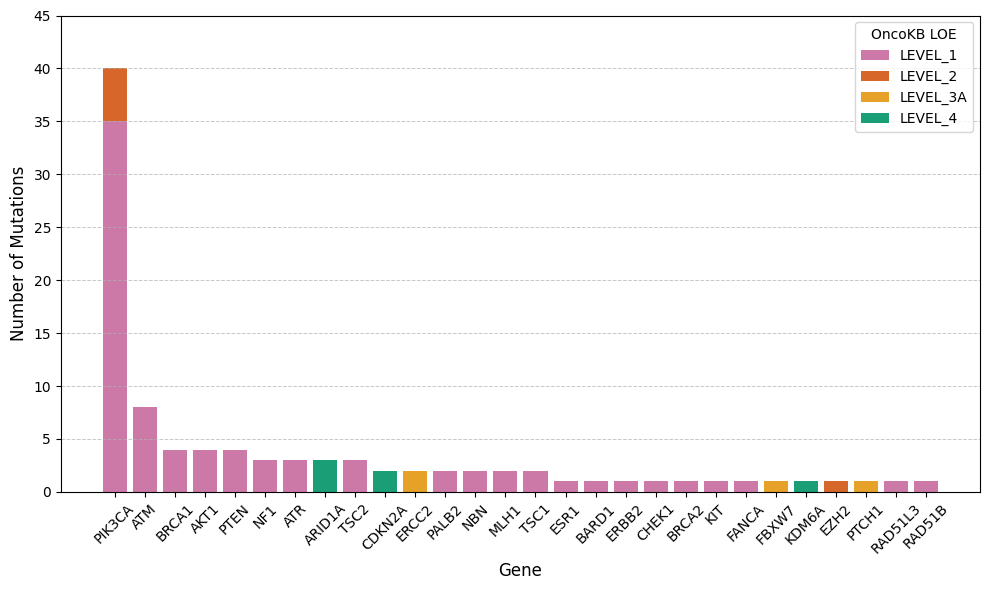

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of each gene by level
gene_counts = frequency_df.groupby(['Gene', 'OncoKB LOE']).size().reset_index(name='Count')

# Pivot data for stacking
pivot_df = gene_counts.pivot(index="Gene", columns="OncoKB LOE", values="Count").fillna(0)

# Sort levels
pivot_df = pivot_df[["LEVEL_1", "LEVEL_2", "LEVEL_3A", "LEVEL_4"]]  

# Calculate total counts and sort by total count (descending)
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=False)
pivot_df = pivot_df.drop(columns=['Total'])  # Drop the helper column after sorting

# Define color palette
palette = {
    "LEVEL_1": "#CD79A8",
    "LEVEL_2": "#D7662A",
    "LEVEL_3A": "#E6A129",
    "LEVEL_4": "#1A9E76"
}

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
bottom = None
for level in pivot_df.columns:
    plt.bar(
        pivot_df.index, 
        pivot_df[level], 
        bottom=bottom, 
        label=level, 
        color=palette[level]
    )
    bottom = pivot_df[level] if bottom is None else bottom + pivot_df[level]

# Add grid lines
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Adjust y-axis limit
plt.ylim(0, 45)

# Add labels and legend
plt.xlabel("Gene", fontsize=12)
plt.ylabel("Number of Mutations", fontsize=12)
plt.title("", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="OncoKB LOE", fontsize=10)
plt.tight_layout()

# Show plot
#plt.show()

plt.savefig("gene_level_barplot.png", format="png", dpi=1200)

In [7]:
# Directory containing your files
directory = "/home/molecularonco/github/nccs-exome2/result/050_tmb/"

# List to store extracted information
data = []

# Loop over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            sample_id = filename.split('_')[0]  # Extract sample ID from filename
            total_variants = 0
            non_informative_variants = 0
            variants_after_filters = 0
            tmb = 0.0
            
            # Extract data from each file
            for line in file:
                line = line.strip()  # Remove any extra whitespace
                if "Total number of variants" in line:
                    total_variants = int(line.split('=')[-1].strip())
                elif "Non-informative variants" in line:
                    non_informative_variants = int(line.split('=')[-1].strip())
                elif "Variants after filters" in line:
                    variants_after_filters = int(line.split('=')[-1].strip())
                elif "TMB" in line:
                    try:
                        tmb = float(line.split('=')[-1].strip())
                    except ValueError:
                        print(f"Could not convert TMB value in file {filename}")
            
            # Append the extracted data to the list
            data.append([sample_id, total_variants, non_informative_variants, variants_after_filters, tmb])

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=['Sample ID', 'Total Variants', 'Non-informative Variants', 'Variants After Filters', 'TMB'])

# Save to a CSV or display
df.to_csv('extracted_tmb_data.csv', index=False)
print(df)

Could not convert TMB value in file z9459_T1_DKDL230009035-1A_HLGLNDSX7_L1.txt
Could not convert TMB value in file z9459_T1_DKDL230009035-1A_HLGLNDSX7_L1.txt
Could not convert TMB value in file z9459_T1_DKDL230009035-1A_HLGLNDSX7_L1.txt
Could not convert TMB value in file z2878_T1_DKDL230010212-1A_HTJYJDSX7_L4.txt
Could not convert TMB value in file z2878_T1_DKDL230010212-1A_HTJYJDSX7_L4.txt
Could not convert TMB value in file z2878_T1_DKDL230010212-1A_HTJYJDSX7_L4.txt
Could not convert TMB value in file BC198_T1_DKDL230008411-1A_HJJMVDSX7_L1.txt
Could not convert TMB value in file BC198_T1_DKDL230008411-1A_HJJMVDSX7_L1.txt
Could not convert TMB value in file BC198_T1_DKDL230008411-1A_HJJMVDSX7_L1.txt
Could not convert TMB value in file z2195_T2_DKDL230010211-1A_HTJYJDSX7_L4.txt
Could not convert TMB value in file z2195_T2_DKDL230010211-1A_HTJYJDSX7_L4.txt
Could not convert TMB value in file z2195_T2_DKDL230010211-1A_HTJYJDSX7_L4.txt
Could not convert TMB value in file z4762_T1_DKDL230

In [19]:
import re

# Directory containing your microsatellite files
microsatellite_dir = "/home/molecularonco/github/nccs-exome2/result/060_msi/"

# Read the TMB DataFrame (containing shorter sample IDs)
tmb_df = pd.read_csv("extracted_tmb_data.csv")

# List to store extracted microsatellite information
microsatellite_data = []

pattern = re.compile(r"_L\d+$")
pattern2 = re.compile(r"_L\d{1}_C$")

# Loop over all files in the microsatellite directory
for filename in os.listdir(microsatellite_dir):
    if pattern2.search(filename) or pattern.search(filename):  # Filter to read only relevant sample files
        filepath = os.path.join(microsatellite_dir, filename)
        with open(filepath, 'r') as file:
            sample_id = filename.split('_')[0]  # Extract only the first part of sample ID (e.g., z9459)
            total_sites = 0
            somatic_sites = 0
            somatic_percentage = 0.0

            # Read the data (assuming three columns exist in the file)
            for line in file:
                if line.startswith("Total_Number_of_Sites"):
                    continue  # Skip the header line
                #print(line)
                total_sites, somatic_sites, somatic_percentage = line.split()
                total_sites = int(total_sites)
                somatic_sites = int(somatic_sites)
                somatic_percentage = float(somatic_percentage)

            # Append the extracted data to the list
            microsatellite_data.append([sample_id, total_sites, somatic_sites, somatic_percentage])

# Convert microsatellite data to a DataFrame
microsatellite_df = pd.DataFrame(microsatellite_data, columns=['Sample ID', 'Total Sites', 'Somatic Sites', 'Somatic %'])

# Merge with the existing TMB DataFrame on 'Sample ID'
merged_df = pd.merge(tmb_df, microsatellite_df, on='Sample ID', how='left')

# Save to a CSV or display
merged_df.to_csv('tmb_microsatellite_data.csv', index=False)
print(merged_df) 


    Sample ID  Total Variants  Non-informative Variants  \
0       z9459          470916                         0   
1       z2878          459298                         0   
2       BC198          446248                         0   
3       z2195          454550                         0   
4       z4762          441069                         0   
..        ...             ...                       ...   
121     z9178          434926                         0   
122      z886          466833                         0   
123     z3736          447708                         0   
124     z8731          457062                         0   
125     z8597          444989                         0   

     Variants After Filters      TMB  Total Sites  Somatic Sites  Somatic %  
0                      1303    39.15        38450             22       0.06  
1                       555    16.68        17343              1       0.01  
2                     43014  1292.49        28858        

In [42]:
# Read the CSV file
df = pd.read_csv('/home/molecularonco/github/nccs-meth3/result/060_methylkit/output_files/methyl_files_T_N.csv')

# Function to extract batch ID
def extract_batch(methyl_name):
    match = re.search(r'_([A-Z0-9]+)_L\d+_sorted', methyl_name)
    return match.group(1) if match else None

# Apply the function to the methyl_name column and create a new column 'batch'
df['batch'] = df['methyl_name'].apply(extract_batch)

# Print the updated dataframe
print(df)

# Optionally, save the updated dataframe back to a CSV file
df.to_csv('/home/molecularonco/github/nccs-meth3/result/060_methylkit/output_files/outputfile.csv', index=False)

         sample_id                                        methyl_name  \
0    BC042_FISH_N1  BC042_FISH_N1_DKDL220013611-1A_HNG3KDSX5_L2_so...   
1    BC047_FISH_N1  BC047_FISH_N1_DKDL220013610-1A_HNG3KDSX5_L2_so...   
2         BC128_N1  BC128_N1_DKDL220013611-1A_HNG3KDSX5_L2_sorted_...   
3         BC133_N1  BC133_N1_DKDL220013614-1A_HNG3KDSX5_L2_sorted_...   
4         BC167_N1  BC167_N1_DKDL220013610-1A_HNG3KDSX5_L2_sorted_...   
..             ...                                                ...   
335       z9704_T2  z9704_T2_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...   
336       z9733_T1  z9733_T1_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...   
337       z9895_T1  z9895_T1_DKDL230002250-1A_H2JVKDSX7_L1_sorted_...   
338        z991_T1  z991_T1_DKDL230008047-1A_HJJJNDSX7_L1_sorted_C...   
339       z9922_T1  z9922_T1_DKDL230002250-1A_H2JVKDSX7_L1_sorted_...   

         batch  
0    HNG3KDSX5  
1    HNG3KDSX5  
2    HNG3KDSX5  
3    HNG3KDSX5  
4    HNG3KDSX5  
..         ...  
335 

In [48]:
df_metadata = pd.read_csv("/home/molecularonco/github/nccs-meth3/result/060_methylkit/output_files/Clinical data.csv")
df_metadata

,S/No.,Visit_TRID,Age at time of collection of specimen,Gender,Date of sample collection _(Month / Year) if cant be too specific,Specimen_Laterality of released tissue\n(STR record),side\n(JBCR record),Institution_code,dob,Age_@_Dx,...,Cause_of_death,MHA_COD,Date_for_DFS,Date_for_OS,Date_for_CSS,Count_as_DFS,Count_as_OS,Count_as_CSS,Followup,AuthoredDate
0,1,BC047,58,Female,Feb-13,Left,left,NCC,Aug-1954,58,...,breast cancer related,MALIGNANT NEOPLASM OF BREAST,Jan-15,Feb-18,Feb-18,RECURRENCE (any),Dead,Death from Ca Breast,60,NaN
1,2,BC242,62,Female,Dec-18,Right,right,NCC,Feb-1956,61,...,NaN,NaN,Oct-17,Jun-21,Jun-21,RECURRENCE (any),Dead,N,44,Jun-21
2,3,BC167,74,Female,Jun-17,Right,right,SGH,Mar-1943,73,...,N,"PNEUMONIA, UNSPECIFIED,MALIGNANT NEOPLASM WITH...",Sep-20,Sep-20,Sep-20,RECURRENCE (any),Dead,N,46,Nov-18
3,4,BC128,38,Female,Aug-11,Left,left,KKH,Jun-1973,37,...,breast cancer related,METASTATIC BREAST CANCER,Apr-16,Feb-17,Feb-17,RECURRENCE (any),Dead,Death from Ca Breast,69,NaN
4,5,BC239,48,Female,Mar-12,Right,right,KKH,Mar-1963,48,...,breast cancer related,CARCINOMA IN SITU OF BREAST,Feb-12,May-18,May-18,RECURRENCE (any),Dead,Death from Ca Breast,75,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,166,z9733,39,Female,Nov-16,Left,left,KKH,May-1977,39,...,NaN,NaN,Sep-22,Sep-22,Sep-22,N,N,N,71,Jul-22
166,167,z10057,42,Female,Jan-17,Right,right,KKH,Apr-1974,42,...,NaN,NaN,Aug-22,Aug-22,Aug-22,N,N,N,68,Feb-18
167,168,z10076,50,Female,Jan-17,Right,right,KKH,Nov-1966,50,...,NaN,NaN,Jan-20,Oct-21,Oct-21,RECURRENCE (any),Dead,N,58,May-19
168,169,z10139,46,Female,Feb-17,Left,left,KKH,Oct-1970,46,...,NaN,NaN,Aug-22,Aug-22,Aug-22,N,N,N,67,Jun-18


In [49]:
columns_to_extract = [
    'Visit_TRID', 
    'Age at time of collection of specimen', 
    'Date of sample collection _(Month / Year) if cant be too specific', 
    'race', 
    'er', 
    'pr', 
    'HER2', 
    'Neo_Adjuvant'
]
metadata = df_metadata[columns_to_extract]
metadata.columns

Index(['Visit_TRID', 'Age at time of collection of specimen',
       'Date of sample collection _(Month / Year) if cant be too specific',
       'race', 'er', 'pr', 'HER2', 'Neo_Adjuvant'],
      dtype='object')

In [50]:
# Remove the suffix from 'sample_id' in df1 to match 'Visit_TRID'
df['Visit_TRID'] = df['sample_id'].str.split('_').str[0]
df


,sample_id,methyl_name,batch,Visit_TRID
0,BC042_FISH_N1,BC042_FISH_N1_DKDL220013611-1A_HNG3KDSX5_L2_so...,HNG3KDSX5,BC042
1,BC047_FISH_N1,BC047_FISH_N1_DKDL220013610-1A_HNG3KDSX5_L2_so...,HNG3KDSX5,BC047
2,BC128_N1,BC128_N1_DKDL220013611-1A_HNG3KDSX5_L2_sorted_...,HNG3KDSX5,BC128
3,BC133_N1,BC133_N1_DKDL220013614-1A_HNG3KDSX5_L2_sorted_...,HNG3KDSX5,BC133
4,BC167_N1,BC167_N1_DKDL220013610-1A_HNG3KDSX5_L2_sorted_...,HNG3KDSX5,BC167
...,...,...,...,...
335,z9704_T2,z9704_T2_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...,HJJJNDSX7,z9704
336,z9733_T1,z9733_T1_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...,HJJJNDSX7,z9733
337,z9895_T1,z9895_T1_DKDL230002250-1A_H2JVKDSX7_L1_sorted_...,H2JVKDSX7,z9895
338,z991_T1,z991_T1_DKDL230008047-1A_HJJJNDSX7_L1_sorted_C...,HJJJNDSX7,z991


In [52]:
# Now merge based on 'Visit_TRID'
df_N_T_clinical_data = pd.merge(df, metadata, on='Visit_TRID', how='left')
df_N_T_clinical_data.to_csv('/home/molecularonco/github/nccs-meth3/result/060_methylkit/output_files//methyl_files_clinical_T_N.csv', index=False)

In [53]:
df_N_T_clinical_data

,sample_id,methyl_name,batch,Visit_TRID,Age at time of collection of specimen,Date of sample collection _(Month / Year) if cant be too specific,race,er,pr,HER2,Neo_Adjuvant
0,BC042_FISH_N1,BC042_FISH_N1_DKDL220013611-1A_HNG3KDSX5_L2_so...,HNG3KDSX5,BC042,46.0,Feb-14,chinese,negative,positive,positive,no
1,BC047_FISH_N1,BC047_FISH_N1_DKDL220013610-1A_HNG3KDSX5_L2_so...,HNG3KDSX5,BC047,58.0,Feb-13,chinese,positive,negative,positive,no
2,BC128_N1,BC128_N1_DKDL220013611-1A_HNG3KDSX5_L2_sorted_...,HNG3KDSX5,BC128,38.0,Aug-11,chinese,positive,positive,negative,no
3,BC133_N1,BC133_N1_DKDL220013614-1A_HNG3KDSX5_L2_sorted_...,HNG3KDSX5,BC133,59.0,Aug-13,malay,positive,negative,negative,no
4,BC167_N1,BC167_N1_DKDL220013610-1A_HNG3KDSX5_L2_sorted_...,HNG3KDSX5,BC167,74.0,Jun-17,chinese,negative,negative,negative,yes
...,...,...,...,...,...,...,...,...,...,...,...
335,z9704_T2,z9704_T2_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...,HJJJNDSX7,z9704,64.0,Oct-16,malay,positive,positive,negative,no
336,z9733_T1,z9733_T1_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...,HJJJNDSX7,z9733,39.0,Nov-16,malay,positive,positive,positive,no
337,z9895_T1,z9895_T1_DKDL230002250-1A_H2JVKDSX7_L1_sorted_...,H2JVKDSX7,z9895,53.0,Dec-16,eurasian,positive,positive,negative,no
338,z991_T1,z991_T1_DKDL230008047-1A_HJJJNDSX7_L1_sorted_C...,HJJJNDSX7,z991,37.0,Mar-12,chinese,negative,negative,negative,yes


In [58]:
# Function to categorize age based on given ranges
def categorize_age(age):
    if 0 <= age < 30:
        return 0
    elif 30 <= age < 35:
        return 2
    elif 35 <= age < 40:
        return 3
    elif 40 <= age < 45:
        return 4
    elif 45 <= age < 50:
        return 5
    elif 50 <= age < 55:
        return 6
    elif 55 <= age < 60:
        return 7
    elif 60 <= age < 65:
        return 8
    elif 65 <= age < 70:
        return 9
    elif age >= 70:
        return 10
    else:
        return None  # Handle any unexpected cases

def extract_year(date):
    try:
        # Split the date by "-" and extract the year part
        month_year = date.split('-')
        # Convert the year part from two digits to four digits (assuming 2000+ for now)
        year = int(month_year[1]) + 2000
        return year
    except:
        return None  # Handle any unexpected cases

# Apply the function to the 'Age at time of collection' column
df_N_T_clinical_data['age_category'] = df_N_T_clinical_data['Age at time of collection of specimen'].apply(categorize_age)
df_N_T_clinical_data['Year of sample collection'] = df_N_T_clinical_data['Date of sample collection _(Month / Year) if cant be too specific'].apply(extract_year)

print(df_N_T_clinical_data)

         sample_id                                        methyl_name  \
0    BC042_FISH_N1  BC042_FISH_N1_DKDL220013611-1A_HNG3KDSX5_L2_so...   
1    BC047_FISH_N1  BC047_FISH_N1_DKDL220013610-1A_HNG3KDSX5_L2_so...   
2         BC128_N1  BC128_N1_DKDL220013611-1A_HNG3KDSX5_L2_sorted_...   
3         BC133_N1  BC133_N1_DKDL220013614-1A_HNG3KDSX5_L2_sorted_...   
4         BC167_N1  BC167_N1_DKDL220013610-1A_HNG3KDSX5_L2_sorted_...   
..             ...                                                ...   
335       z9704_T2  z9704_T2_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...   
336       z9733_T1  z9733_T1_DKDL230008052-1A_HJJJNDSX7_L1_sorted_...   
337       z9895_T1  z9895_T1_DKDL230002250-1A_H2JVKDSX7_L1_sorted_...   
338        z991_T1  z991_T1_DKDL230008047-1A_HJJJNDSX7_L1_sorted_C...   
339       z9922_T1  z9922_T1_DKDL230002250-1A_H2JVKDSX7_L1_sorted_...   

         batch Visit_TRID  Age at time of collection of specimen  \
0    HNG3KDSX5      BC042                              

In [59]:
df_N_T_clinical_data.to_csv('/home/molecularonco/github/nccs-meth3/result/060_methylkit/output_files//methyl_files_clinical_T_N.csv', index=False)

In [7]:
exome_xlsx = pd.read_excel("exome_analysis_v1.1.xlsx")
exome_xlsx

,Tumor_Sample_Barcode,Chr,Start,End,Ref,Alt,Gene,cDNA Change,Protein Change,Func,...,MutationTaster_score,MutationTaster_pred,FATHMM_score,FATHMM_pred,Polyphen2_HVAR_score,Polyphen2_HVAR_pred,REVEL,CADD,CLNREVSTAT,CLNSIG
0,z7681_T2_DKDL230010209-1A_HTJYJDSX7_L3,chr7,152181202,152181202,G,A,KMT2C,NM_170606.3:c.6658C>T,NP_733751.2:p.(Gln2220*),exonic,...,1.0,D,.,.,.,.,NaN,49.00,NaN,NaN
1,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr7,152265049,152265049,G,T,KMT2C,NM_170606.3:c.1173C>A,NP_733751.2:p.(Cys391*),exonic,...,1.0,D,.,.,.,.,NaN,39.00,no_assertion_criteria_provided,Conflicting_interpretations_of_pathogenicity
2,z3521_T1_DKDL230010210-1A_HTJYJDSX7_L3,chr7,152265180,152265180,C,T,KMT2C,NM_170606.3:c.1042G>A,NP_733751.2:p.(Asp348Asn),exonic,...,1.0,D,-5.15,D,0.99,D,0.624,15.09,criteria_provided\x2c_single_submitter,Uncertain_significance
3,BC133_T1_DKDL230008411-1A_HJJMVDSX7_L1,chr7,152265180,152265180,C,T,KMT2C,NM_170606.3:c.1042G>A,NP_733751.2:p.(Asp348Asn),exonic,...,1.0,D,-5.15,D,0.99,D,0.624,15.09,criteria_provided\x2c_single_submitter,Uncertain_significance
4,z3521_T1_DKDL230010210-1A_HTJYJDSX7_L3,chr7,152265205,152265205,C,G,KMT2C,NM_170606.3:c.1017G>C,NP_733751.2:p.(Lys339Asn),exonic,...,1.0,D,-5.16,D,0.991,D,0.572,6.18,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,z5228_T1_DKDL230009039-1A_HLGGCDSX7_L1_C,chr12,65062541,65062541,A,G,WIF1,NM_007191.5:c.766T>C,NP_009122.2:p.(Cys256Arg),exonic,...,1.0,D,-5.72,D,0.979,D,0.964,20.50,NaN,NaN
1129,z7841_T1_DKDL230009034-1A_HLGLNDSX7_L1,chr11,32416552,32416552,G,A,WT1,NM_024426.6:c.966-12C>T,NP_077744.4:p.(=),intronic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,z10455_T1_DKDL230009035-1A_HLGLNDSX7_L1,chr11,32392692,32392692,A,T,WT1,NM_024426.6:c.1328T>A,NP_077744.4:p.(Leu443His),exonic,...,1.0,D,0.59,T,0.994,D,0.660,29.00,NaN,NaN
1131,z3736_T1_DKDL230009037-1A_HLGLNDSX7_L2,chr20,53582126,53582126,T,A,ZNF217,NM_006526.3:c.701A>T,NP_006517.1:p.(His234Leu),exonic,...,1.0,D,0.65,T,1,D,0.578,19.51,NaN,NaN


In [6]:
oncoplot_new = os.path.join(directory, "oncoplot_new.txt")
exome_xlsx.to_csv(oncoplot_new, sep="\t", index=False)